In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
listings = pd.read_csv("listings.csv")
listings.shape

(3818, 92)

In [168]:
def drop_single_value_columns(df):
    """ Function to drop columns with single value """
    df_col = df.columns
    df_col_drop = []
    for col in df_col:
        if len(df[col].value_counts()) == 1:
            df_col_drop.append(col)
    df.drop(columns=df_col_drop, inplace=True)

drop_single_value_columns(listings)

listings.cleaning_fee = listings.cleaning_fee[listings.cleaning_fee.notna()].str.replace('$', '').astype(float)
listings.security_deposit = listings.security_deposit[listings.security_deposit.notna()].str.replace(',', '').str.replace('$', '').astype(float)
listings.price = listings.price[listings.price.notna()].str.replace(',', '').str.replace('$', '').astype(float)

listings.cleaning_fee = listings.cleaning_fee.fillna(listings.cleaning_fee[listings.cleaning_fee.notna()].std())
listings.security_deposit = listings.security_deposit.fillna(listings.security_deposit[listings.security_deposit.notna()].std())

listings.review_scores_rating = listings.review_scores_rating.fillna(listings.review_scores_rating[listings.review_scores_rating.notna()].mean())
listings.review_scores_accuracy = listings.review_scores_accuracy.fillna(listings.review_scores_accuracy[listings.review_scores_accuracy.notna()].mean())
listings.review_scores_cleanliness = listings.review_scores_cleanliness.fillna(listings.review_scores_cleanliness[listings.review_scores_cleanliness.notna()].mean())
listings.review_scores_location = listings.review_scores_location.fillna(listings.review_scores_location[listings.review_scores_location.notna()].mean())
listings.review_scores_value = listings.review_scores_value.fillna(listings.review_scores_value[listings.review_scores_value.notna()].mean())
listings.reviews_per_month = listings.reviews_per_month.fillna(listings.reviews_per_month[listings.reviews_per_month.notna()].mean())

In [169]:
# This parameters do not affect price (0 - 0.02)
listings.host_is_superhost = listings.host_is_superhost.apply(lambda x: 1 if (x == 't') else 0)
listings.is_location_exact = listings.is_location_exact.apply(lambda x: 1 if (x == 't') else 0)
listings.host_identity_verified = listings.host_identity_verified.apply(lambda x: 1 if (x == 't') else 0)

listings.instant_bookable = listings.instant_bookable.apply(lambda x: 1 if (x == 't') else 0)
listings.require_guest_profile_picture = listings.require_guest_profile_picture.apply(lambda x: 1 if (x == 't') else 0)
listings.require_guest_phone_verification = listings.require_guest_phone_verification.apply(lambda x: 1 if (x == 't') else 0)

# This parameter does not affect price(0.00)
listings.zipcode.loc[listings.zipcode == '99\n98122'] = 98122
listings.zipcode.dropna(inplace=True)
listings.zipcode = listings.zipcode.astype('int64')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [170]:
listings.zipcode.dtype

dtype('float64')

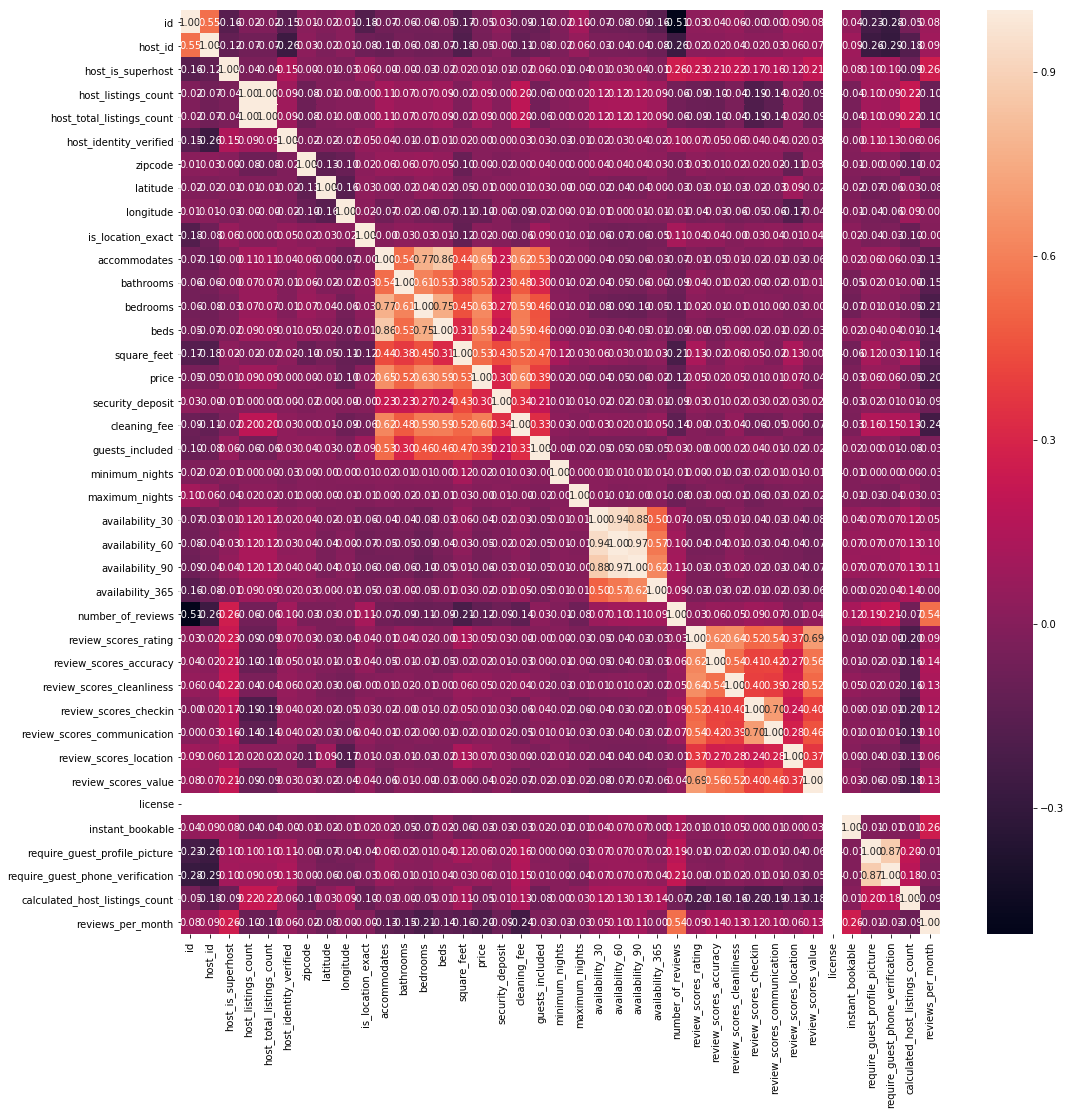

In [171]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(listings.corr(), annot=True, fmt=".2f");

In [172]:
c = listings.corr().abs()
s = c.unstack()
r = s.loc['price'].sort_values(ascending=False)[0:20]
r

price                               1.000000
accommodates                        0.652218
bedrooms                            0.627720
cleaning_fee                        0.599850
beds                                0.589525
square_feet                         0.531752
bathrooms                           0.516424
guests_included                     0.392875
security_deposit                    0.301618
reviews_per_month                   0.199620
number_of_reviews                   0.124695
longitude                           0.102420
host_listings_count                 0.093962
host_total_listings_count           0.093962
review_scores_location              0.068178
require_guest_profile_picture       0.063297
availability_90                     0.058810
require_guest_phone_verification    0.057599
calculated_host_listings_count      0.054092
host_id                             0.051332
dtype: float64

In [173]:
col_num = listings.select_dtypes(include=np.number).columns.tolist()

col_for_price = list(r.index)
listings_col_drop = set(col_num) - set(col_for_price)

In [174]:
listings.drop(columns=listings_col_drop, inplace=True)

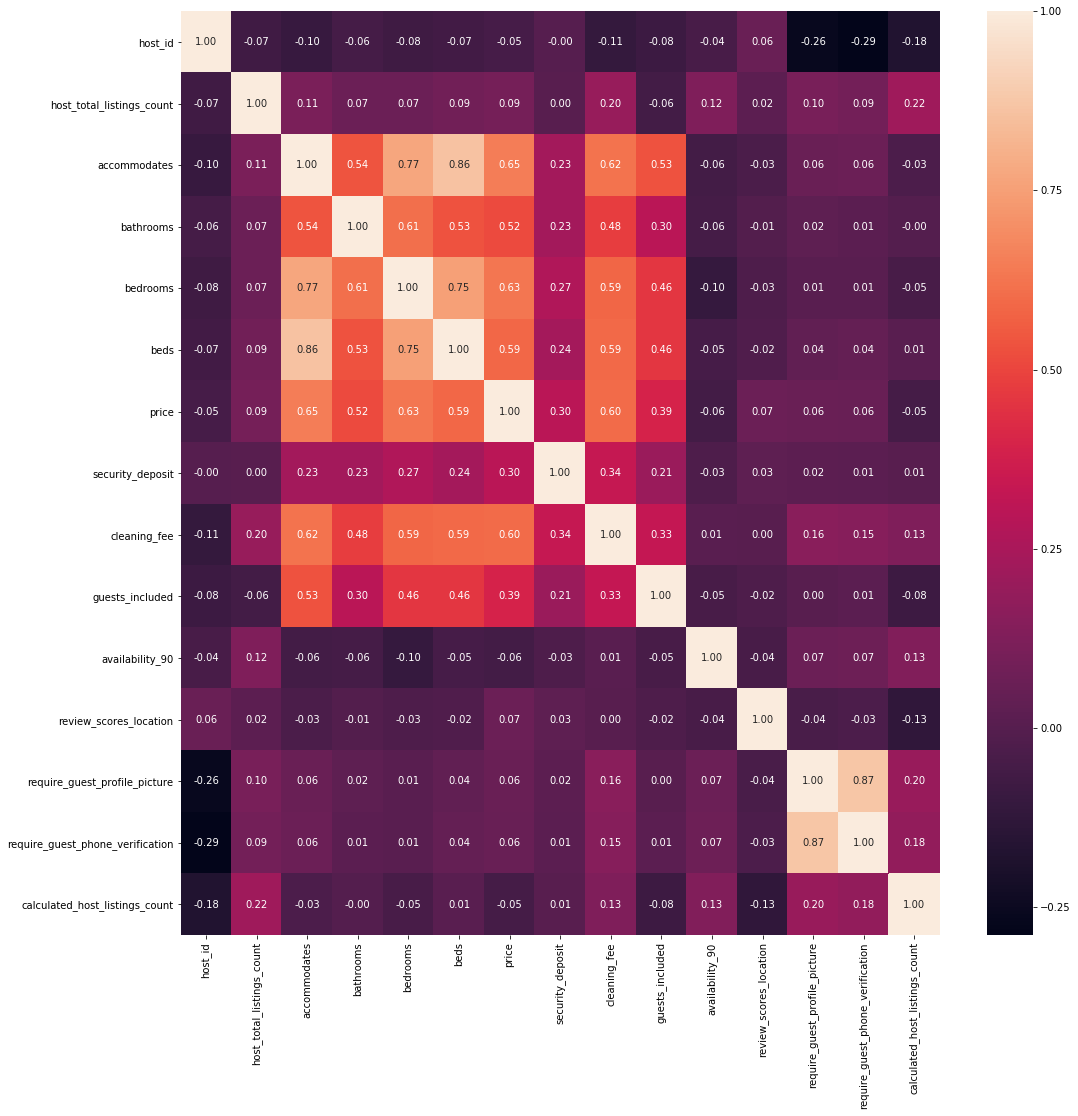

In [175]:
listings2 = listings.drop(columns=['host_listings_count',
                                   
                                  'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
                                  'listing_url', 'name', 'summary', 'description', 'space', 'neighborhood_overview', 'notes', 'transit',
                                  'host_thumbnail_url', 'host_picture_url', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                                  'host_since', 'host_neighbourhood', 'weekly_price', 'square_feet', 'host_about', 'neighbourhood',
                                  'monthly_price', 'first_review', 'last_review', 'host_url', 'host_name', 'host_location',
                                  'host_has_profile_pic', 'city', 'state', 'host_verifications', 'street', 'calendar_updated',
                                  'extra_people', 'smart_location', 'neighbourhood_cleansed',
                                  'number_of_reviews', 'longitude', 'reviews_per_month'
                                  ])


# 'license', 'availability_60', 'availability_90', 'availability_365', 'host_id', 'review_scores_checkin', 'review_scores_communication', 'minimum_nights',
# 'latitude', 'zipcode', 'review_scores_accuracy', 'host_is_superhost', 'host_identity_verified', 'is_location_exact', 'id'


fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(listings2.corr(), annot=True, fmt=".2f");

In [176]:
listings = listings2
listings_col = list(listings2.columns)
listings.isna().sum()

host_id                              0
host_total_listings_count            2
neighbourhood_group_cleansed         0
property_type                        1
room_type                            0
accommodates                         0
bathrooms                           16
bedrooms                             6
beds                                 1
bed_type                             0
amenities                            0
price                                0
security_deposit                     0
cleaning_fee                         0
guests_included                      0
availability_90                      0
review_scores_location               0
cancellation_policy                  0
require_guest_profile_picture        0
require_guest_phone_verification     0
calculated_host_listings_count       0
dtype: int64

In [177]:
amenities = set()

for row in range(0, listings.shape[0]):
    amenities_row = list(listings['amenities'][row].strip('{}').split(','))
    for item in amenities_row:
        amenities.add(item)

for item in amenities:
    listings[item] = 0
    listings.loc[listings.amenities.map(set(item).issubset), item] = 1

amenities.remove('')
    
amenities_vs_price = listings  #I create another dataset for another question

amenities_correlation = listings

listings.describe()

,host_id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,Heating,"""Buzzer/Wireless Intercom""","""Air Conditioning""",Dryer,"""Laptop Friendly Workspace""","""Wheelchair Accessible""","""Family/Kid Friendly""",Iron,"""Elevator in Building""",Kitchen
count,3.818000e+03,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,1.578556e+07,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,278.720715,58.236053,1.672603,...,0.956260,0.140911,0.561551,0.913829,0.206129,0.536668,0.559193,0.961236,0.239916,0.950498
std,1.458382e+07,28.628149,1.977599,0.590369,0.883395,1.139480,90.250022,189.086087,42.115011,1.311040,...,0.204543,0.347976,0.496262,0.280653,0.404577,0.498719,0.496549,0.193057,0.427088,0.216943
min,4.193000e+03,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,95.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.275204e+06,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,250.000000,35.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,1.055814e+07,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,270.222690,48.830341,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,2.590309e+07,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,270.222690,65.000000,2.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,5.320861e+07,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,5000.000000,300.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [178]:
listings.dropna(inplace=True)

In [179]:
listings.drop(columns='amenities', inplace=True)

listings.shape

(3793, 62)

In [180]:
listings_col.remove('amenities')
listings_col.remove('price')

In [181]:
listings.loc[listings['cancellation_policy'] == 'strict', 'cancellation_policy'] = 1
listings.loc[listings['cancellation_policy'] == 'moderate', 'cancellation_policy'] = 2
listings.loc[listings['cancellation_policy'] == 'flexible', 'cancellation_policy'] = 3

listings.loc[listings['room_type'] == 'Shared room', 'room_type'] = 1
listings.loc[listings['room_type'] == 'Private room', 'room_type'] = 2
listings.loc[listings['room_type'] == 'Entire home/apt', 'room_type'] = 3

listings.loc[listings['bed_type'] == 'Airbed', 'bed_type'] = 0
listings.loc[listings['bed_type'] == 'Futon', 'bed_type'] = 1
listings.loc[listings['bed_type'] == 'Couch', 'bed_type'] = 1.5
listings.loc[listings['bed_type'] == 'Pull-out Sofa', 'bed_type'] = 2
listings.loc[listings['bed_type'] == 'Real Bed', 'bed_type'] = 3

In [182]:
property_type_counts = listings.property_type.value_counts()

for index, count in property_type_counts.items():
    if count < 100:
        listings.drop(listings[listings['property_type'] == index].index, inplace=True)

## Question 1: "Predict price for rooms"

In [183]:
col_num = listings.select_dtypes(include=np.number).columns.tolist()
col_str = list(listings.columns)

for col in listings.columns:
    if col in col_num:
          col_str.remove(col)

In [184]:
y = listings.price
X = listings.drop(columns='price')

X = pd.get_dummies(data=X, columns=col_str, drop_first=True)

X_norm = scale(X)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.30, random_state=1)

In [186]:
model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [187]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_pred))

0.626865608257
0.579120918923


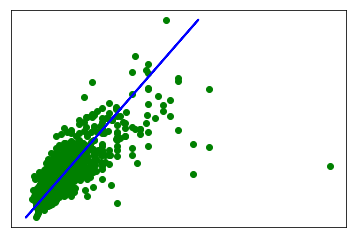

In [188]:
plt.scatter(y_test, y_pred,  color='green')
plt.plot(y_pred, y_pred, color='blue', linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()

## Question 2: "How amenities correlate to each other and affecting price?"

In [189]:
"""
amenities_correlation = amenities_correlation.loc[amenities_correlation.room_type == 3]
amenities_correlation = amenities_correlation.loc[amenities_correlation.neighbourhood_group_cleansed == 'Downtown']
amenities_correlation = amenities_correlation.loc[amenities_correlation.property_type == 'Apartment']
amenities_correlation = amenities_correlation.loc[amenities_correlation.cancellation_policy == 1]
"""

amenities_correlation.drop(columns=listings_col, inplace=True)
amenities_correlation.describe()

,price,,"""Pets Allowed""","""Suitable for Events""",Shampoo,Doorman,"""Pets live on this property""",Internet,"""Safety Card""","""Washer / Dryer""",...,Heating,"""Buzzer/Wireless Intercom""","""Air Conditioning""",Dryer,"""Laptop Friendly Workspace""","""Wheelchair Accessible""","""Family/Kid Friendly""",Iron,"""Elevator in Building""",Kitchen
count,3537.000000,3537.0,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,...,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000,3537.000000
mean,127.759118,1.0,0.133164,0.141928,0.793893,0.956743,0.309019,0.975968,0.252474,0.573650,...,0.959005,0.132033,0.557817,0.919141,0.201583,0.534634,0.560362,0.965225,0.225898,0.957591
std,89.561158,0.0,0.339800,0.349026,0.404565,0.203464,0.462154,0.153169,0.434493,0.494616,...,0.198307,0.338574,0.496716,0.272658,0.401239,0.498870,0.496413,0.183236,0.418231,0.201548
min,20.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,100.000000,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,150.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1000.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [190]:
#X = X.drop(columns=['"Other pet(s)"', '"Buzzer/Wireless Intercom"', 'Gym', 'Breakfast', 'TV', '"Cable TV"', '"Hot Tub"',
#                    '"Lock on Bedroom Door"', '"Family/Kid Friendly"']) #'"Laptop Friendly Workspace"', '"24-Hour Check-in"', "Elevator in Building"

#amenities_correlation = amenities_correlation.drop(columns=['"Other pet(s)"', '"Buzzer/Wireless Intercom"', 'Gym', 'Breakfast', 'TV', '"Cable TV"', '"Hot Tub"',
 #                   '"Lock on Bedroom Door"'])

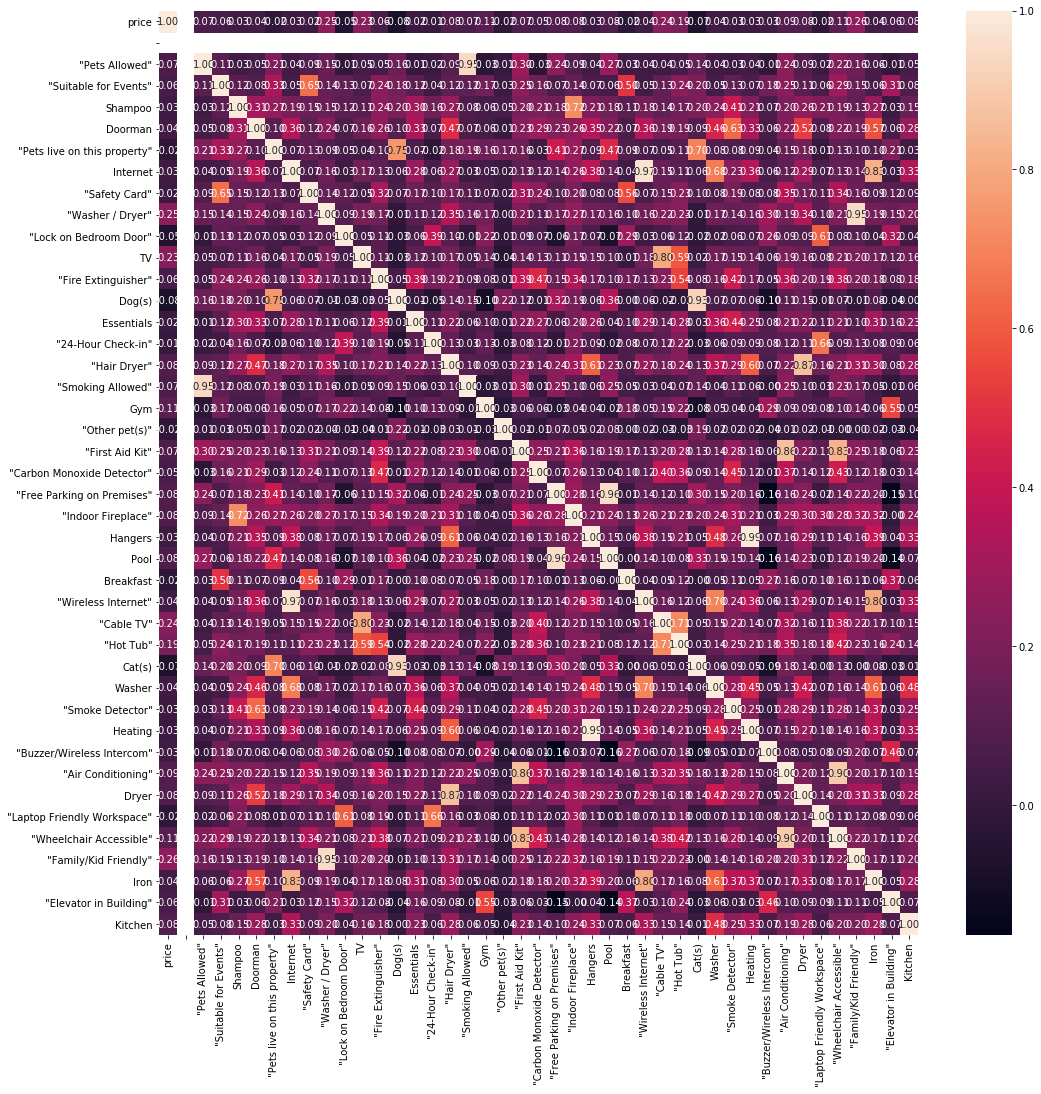

In [191]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(amenities_correlation.corr(), annot=True, fmt=".2f");

### Predict price with top amenities which affect prediction

In [192]:
c = amenities_correlation.corr().abs()
s = c.unstack()
r = s.loc['price'].sort_values(ascending=False)[0:15]
r

price                         1.000000
"Family/Kid Friendly"         0.255854
"Washer / Dryer"              0.250428
"Cable TV"                    0.236466
TV                            0.228463
"Hot Tub"                     0.190113
Gym                           0.110309
"Wheelchair Accessible"       0.109519
"Air Conditioning"            0.088410
Kitchen                       0.084851
Dryer                         0.084381
"Hair Dryer"                  0.081166
"Indoor Fireplace"            0.079661
"Free Parking on Premises"    0.079656
Dog(s)                        0.079022
dtype: float64

In [193]:
amenities_for_price = list(r.index)
amenities_for_price

['price',
 '"Family/Kid Friendly"',
 '"Washer / Dryer"',
 '"Cable TV"',
 'TV',
 '"Hot Tub"',
 'Gym',
 '"Wheelchair Accessible"',
 '"Air Conditioning"',
 'Kitchen',
 'Dryer',
 '"Hair Dryer"',
 '"Indoor Fireplace"',
 '"Free Parking on Premises"',
 'Dog(s)']

In [194]:
amenities_col_drop = set(amenities_correlation.columns) - set(amenities_for_price)
amenities_col_drop

{'',
 '"24-Hour Check-in"',
 '"Buzzer/Wireless Intercom"',
 '"Carbon Monoxide Detector"',
 '"Elevator in Building"',
 '"Fire Extinguisher"',
 '"First Aid Kit"',
 '"Laptop Friendly Workspace"',
 '"Lock on Bedroom Door"',
 '"Other pet(s)"',
 '"Pets Allowed"',
 '"Pets live on this property"',
 '"Safety Card"',
 '"Smoke Detector"',
 '"Smoking Allowed"',
 '"Suitable for Events"',
 '"Wireless Internet"',
 'Breakfast',
 'Cat(s)',
 'Doorman',
 'Essentials',
 'Hangers',
 'Heating',
 'Internet',
 'Iron',
 'Pool',
 'Shampoo',
 'Washer'}

In [195]:
X.drop(columns=amenities_col_drop, inplace=True)

In [196]:
X_norm = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.30, random_state=1)

model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [197]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_pred))

0.6210936115
0.575163584523


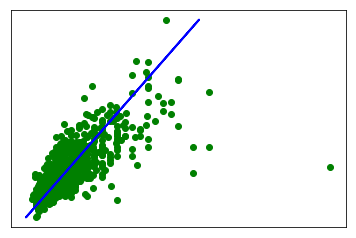

In [198]:
plt.scatter(y_test, y_pred,  color='green')
plt.plot(y_pred, y_pred, color='blue', linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()

## Question 3: What is the most expensive amenities?

In [199]:
#According to EmploymentStatus, which group has the highest average job satisfaction?

df2 = pd.DataFrame(columns=['min', 'max', 'mean', 'std'])

for item in amenities:
    df2.loc[item, 'min'] = amenities_vs_price['price'][amenities_vs_price[item] == 1].min()
    df2.loc[item, 'max'] = amenities_vs_price['price'][amenities_vs_price[item] == 1].max()
    df2.loc[item, 'mean'] = amenities_vs_price['price'][amenities_vs_price[item] == 1].mean()
    df2.loc[item, 'std'] = amenities_vs_price['price'][amenities_vs_price[item] == 1].std()

print('The most expensive amenities based on STD price: ',list(df2.sort_values(by=['std'], ascending=False).index[0:5]))

The most expensive amenities based on STD price:  ['"Smoking Allowed"', '"Pets Allowed"', '"Family/Kid Friendly"', '"Suitable for Events"', '"Washer / Dryer"']
